This notebook contains code for Chapter 3 in Aurelien Geron's Hands-on Machine Learning book. Aurelien has kindly provided his own notebook for all the chapters, but this notebook is my own with my own commentaries and notes for my own learning.

# MNIST

In [ ]:
# fetching the MNIST dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X, y = mnist.data, mnist.target

## Plot a digit using matplotlib

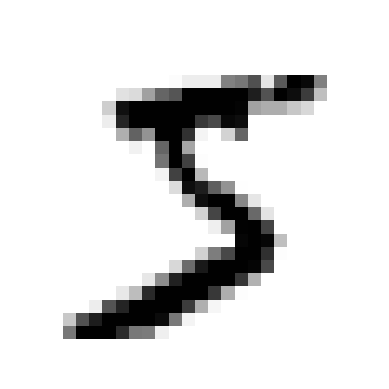

In [ ]:


import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")


some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [ ]:
y[0]

'5'

## Splitting the training set and the test set

In [ ]:

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
X_train.shape

(60000, 784)

## Training a Binary Classifier

In [ ]:
y_train_5 = (y_train == '5') # True for all 5s, false for all other digits
y_test_5 = (y_test == '5')

In [ ]:
# Let's use Stochastic Gradient Descent
'''
SGD - 1. capable of handling very large datasets efficiently
      2. Deals with training instances individually, one at a time
      3. Suitable for online learning
'''

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([X_train[1]])

array([False])

## Performance Measure

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

### Confusion Matrices

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics  import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision, Recall, & F1 score

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([ True])

#### Raising the threshold

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually reprersents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

### Precision recall curve

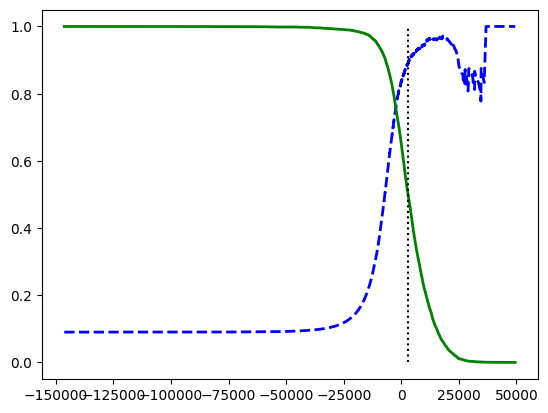

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

### Precision vs recall curve

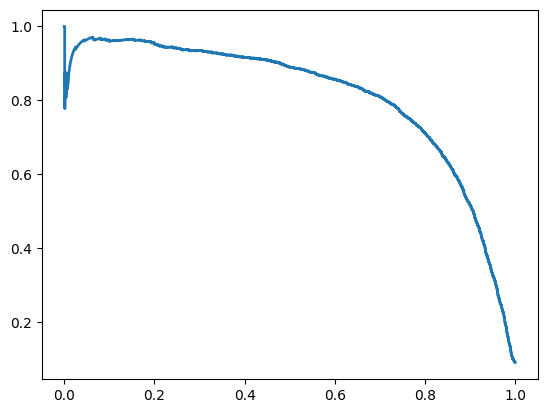

In [ ]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

### Threshold for specific precision

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [ ]:
# Let's try to achieve 90% precision, but it will cost us recall

y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

In [ ]:
# ROC - Receiver Operating Characteristic Curve : plots recalls vs False Positive Rate (FPR), FPR = 1-TNR (True Negative Rate) TNR aka Speficity
# Hence, ROC plots sensitivity versus 1-specificity

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


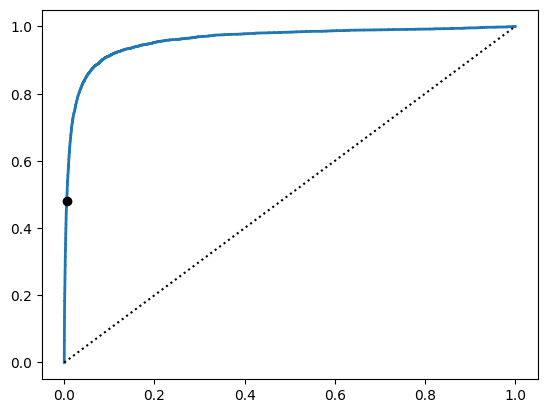

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90, = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

In [ ]:
# measuring AUC - Area under curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

roc_auc_score = 1 == perfect

### Performance measure with RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")




array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

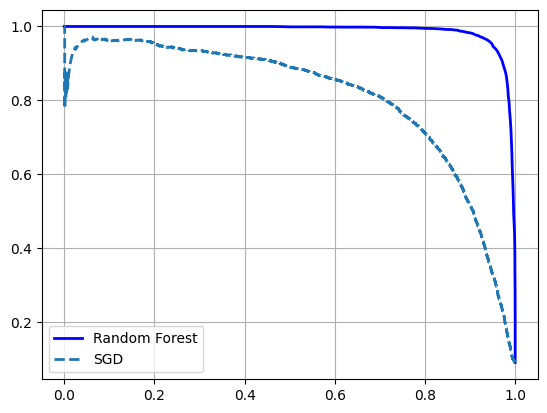

In [ ]:
# Plotting the PR curve
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label ="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.grid()
plt.legend(loc="lower left")

plt.show()

Comparing PR curves: the random forest classifier is superior to the SGD
classifier because its PR curve is much closer to the top-right corner, and it has a greater
AUC

#### ROC and AUC of random forest

In [ ]:

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5,  y_train_pred_forest)

0.9274509803921569

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

#### Precision and Recall of RandomForestClassifier

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Multiclass Classification

### Multiclass Classification with SVC

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [ ]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [ ]:
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [ ]:
class_id_of_some_digit = some_digit_scores.argmax()
class_id_of_some_digit

5

In [ ]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
svm_clf.classes_[class_id_of_some_digit]

'5'

#### Multiclass Classifier using the OvR stragety, based on an SVC:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [ ]:
# Let's make a prediction and check the number of trained classifiers:

ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [ ]:
len(ovr_clf.classes_)

10

In [ ]:
ovr_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [ ]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

#### SGDClassifier or multiclass dataset

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Wrong!!!!

In [ ]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# Let's try scaling with improve the scores:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

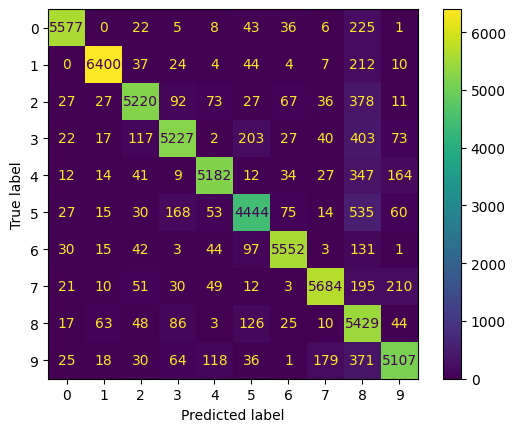

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()